조정효 'Advanced In Financial Machine Learning Chapter3 Exercise'\
Thanks to BlackArbsCEO and mlfinlab

In [1]:
import numpy as np
import pandas as pd
!pip install -q mlfinlab
import mlfinlab
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 61kB 2.4MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file = '/content/drive/My Drive/Colab Notebooks/parq/clean_IVE_tickbidask.parq'

In [3]:
data = pd.read_parquet(file)
data.head()

,price,bid,ask,vol,dollar_vol
date,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


In [0]:
data.to_csv('/content/drive/My Drive/Colab Notebooks/csv/'+'clean_IVE_tickbidask.csv')

In [0]:
data_for_mlfinlab = data.drop(columns=['bid','ask','dollar_vol'])
data_for_mlfinlab.to_csv('/content/drive/My Drive/Colab Notebooks/csv/'+'clean_IVE_tickbidask2.csv')

In [0]:
from mlfinlab import data_structures, features, filters, labeling

# 3.1.

In [7]:
#달러 바 만들기

raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
#threshold = 1백만

Reading data in batches:
Batch number: 0
Returning bars 



In [8]:
#다듬기
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars.head()


,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.79,51.07,50.710,51.07,19844
2009-09-28 09:53:49,51.07,51.15,51.050,51.14,20324
2009-09-28 09:55:26,51.14,51.15,51.129,51.14,19622
2009-09-28 10:02:52,51.14,51.26,51.080,51.25,22319
2009-09-28 10:10:21,51.25,51.29,51.190,51.29,21519


In [9]:
#바 개수

len(dollar_bars)

59578

In [11]:
#인덱스 타임존 빼기 (그냥 해봄)

newindex = dollar_bars.index.tz_convert(None)
dollar_bars.index = newindex
len(dollar_bars)

TypeError: ignored

In [12]:
#겹치는 인덱스 빼기 (편의를 위해 - 이렇게 해야 됨)
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')
dollar_bars.head()
len(dollar_bars)

58607

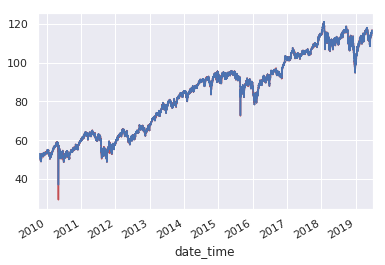

In [13]:
#그래프로 보기(잘 안보임)

data.price.plot(c='r')
dollar_bars.close.plot(c='b')

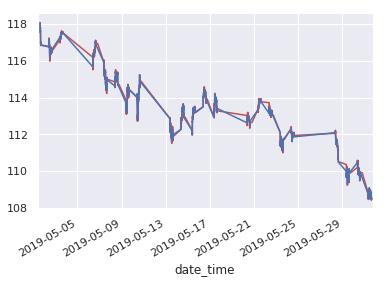

In [14]:
#그래프로 보기 - 2019-05 (조금 보임)

data.price.loc['2019-05'].plot(c='r')
dollar_bars.close.loc['2019-05'].plot(c='b')

In [0]:
close = dollar_bars.close

#close

## (a)

In [0]:
# Cusum filter의 임계값 구하기 (일별변동성)

def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [0]:
DailyVol = getDailyVol(close)

In [18]:
DailyVol = DailyVol.dropna()
DailyVol.head()

date_time
2009-09-29 10:04:46    0.005981
2009-09-29 10:31:39    0.004469
2009-09-29 10:52:23    0.004376
2009-09-29 11:34:53    0.004261
2009-09-29 12:00:17    0.004977
Name: dailyVol, dtype: float64

In [19]:
# 일별변동성의 평균으로 임계값 설정

threshold_forcusum = DailyVol.mean()
threshold_forcusum

0.007361793465500182

In [20]:
# cusum filter로 index 추출

cusum_index = filters.cusum_filter(close,threshold_forcusum)
cusum_index

DatetimeIndex(['2009-09-28 12:33:18', '2009-09-29 09:27:39',
               '2009-09-29 12:00:17', '2009-09-30 09:44:47',
               '2009-09-30 09:56:31', '2009-09-30 12:48:14',
               '2009-09-30 15:05:38', '2009-10-01 09:52:26',
               '2009-10-01 11:16:04', '2009-10-01 15:51:53',
               ...
               '2019-06-07 11:17:10', '2019-06-10 09:46:45',
               '2019-06-12 10:18:41', '2019-06-17 09:57:13',
               '2019-06-18 09:39:43', '2019-06-20 09:30:00',
               '2019-06-20 12:20:48', '2019-06-20 15:50:44',
               '2019-06-25 09:42:50', '2019-06-28 09:30:00'],
              dtype='datetime64[ns]', length=3165, freq=None)

In [0]:

t_events = cusum_index

#t_events

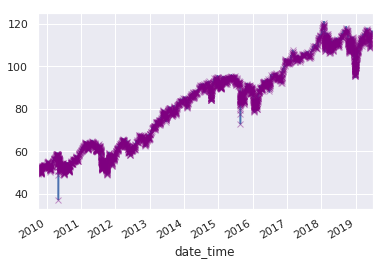

In [22]:
#cusum filtered index 보기 (잘 안보임)

f,ax=plt.subplots()
close.plot(ax=ax,c='b')
close.loc[cusum_index].plot(ax=ax,c='purple', marker = 'x', ls='',alpha=0.4)

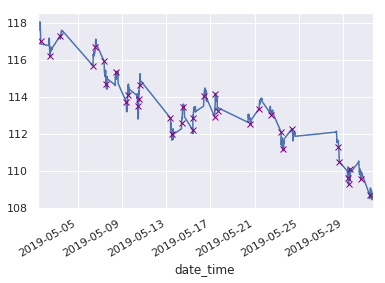

In [23]:
#cusum filtered index 보기 (조금 보임)

f,ax=plt.subplots()
close.loc['2019-05'].plot(ax=ax,c='b')
close.loc[cusum_index].loc['2019-05'].plot(ax=ax,c='purple', marker = 'x',ls='', )

## (b)

In [0]:
#vertical barrier 추가 (num_days=1)

vertical_barrier = labeling.add_vertical_barrier(t_events,close,num_days=1)

In [25]:
vertical_barrier

2009-09-28 12:33:18   2009-09-29 12:34:54
2009-09-29 09:27:39   2009-09-30 09:32:03
2009-09-29 12:00:17   2009-09-30 12:48:14
2009-09-30 09:44:47   2009-10-01 09:52:26
2009-09-30 09:56:31   2009-10-01 10:00:15
2009-09-30 12:48:14   2009-10-01 13:09:57
2009-09-30 15:05:38   2009-10-01 15:17:05
2009-10-01 09:52:26   2009-10-02 10:02:18
2009-10-01 11:16:04   2009-10-02 11:19:52
2009-10-01 15:51:53   2009-10-02 15:54:20
2009-10-01 16:16:36   2009-10-05 09:35:27
2009-10-02 09:32:42   2009-10-05 09:35:27
2009-10-02 10:34:31   2009-10-05 09:35:27
2009-10-05 10:09:51   2009-10-06 10:13:47
2009-10-05 12:55:39   2009-10-06 13:09:38
2009-10-06 09:31:29   2009-10-07 09:47:25
2009-10-06 11:16:28   2009-10-07 12:14:25
2009-10-06 14:08:35   2009-10-07 14:12:08
2009-10-07 11:04:15   2009-10-08 11:29:32
2009-10-08 09:29:50   2009-10-09 09:41:48
2009-10-12 09:43:45   2009-10-13 10:02:16
2009-10-13 10:02:16   2009-10-14 10:19:31
2009-10-14 09:34:13   2009-10-15 09:59:26
2009-10-14 15:04:11   2009-10-15 1

In [26]:
type(vertical_barrier)

pandas.core.series.Series

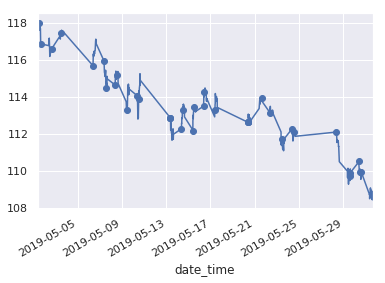

In [27]:
#그림으로 보기 (수직선으로 그리고 시작선 끝선 표시하고 싶은데 못하겠습니다.)

f,ax=plt.subplots()
dollar_bars.close.loc['2019-05'].plot(ax=ax,c='b')
dollar_bars.close.loc[vertical_barrier].loc['2019-05'].plot(ax=ax,marker='o',ls='')
#수직선 그리는법..


## (c)

In [28]:
# Tripple Barrier 기법

# 1. events 만들기 (ptsl=[1.1])

pt_sl = [1,1]
target = DailyVol

#1.1. side를 설정안 한 경우 만들기


events = labeling.get_events(close, t_events, pt_sl, target, min_ret=0.01, num_threads=1 ,vertical_barrier_times=vertical_barrier, side_prediction=None )
events
#no side

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


,t1,trgt
2009-10-02 09:32:42,2009-10-02 10:36:37,0.010414
2009-10-02 10:34:31,2009-10-05 09:35:27,0.010400
2009-10-05 12:55:39,2009-10-06 09:31:29,0.011719
2009-10-06 09:31:29,2009-10-07 09:47:25,0.016259
2009-10-06 11:16:28,2009-10-07 12:14:25,0.017185
2009-10-06 14:08:35,2009-10-07 14:12:08,0.017471
2009-10-07 11:04:15,2009-10-08 11:29:32,0.015954
2009-10-08 09:29:50,2009-10-09 09:41:48,0.014741
2009-10-12 09:43:45,2009-10-13 10:02:16,0.012437
2009-10-13 10:02:16,2009-10-14 09:34:13,0.011074


In [29]:
#1.2. side 설정한 경우 (메타레이블)

 # 3.4.번 문제에서도 활용되기에 미리 메타레이블을 만들어보자. side를 정하자.
 #side는 교차 ewm 사용.

fast_window = 3
slow_window = 6

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))

def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

side

#side

date_time
2009-09-29 15:53:15   -1
2009-09-30 09:32:03    1
2009-09-30 09:44:47   -1
2009-10-05 10:09:51    1
2009-10-13 10:02:16   -1
2009-10-14 09:34:13    1
2009-10-16 09:38:27   -1
2009-10-19 10:28:55    1
2009-10-20 11:48:54   -1
2009-10-21 09:52:55    1
2009-10-21 15:18:03   -1
2009-10-22 14:41:20    1
2009-10-23 11:22:52   -1
2009-10-29 10:51:55    1
2009-10-30 11:38:14   -1
2009-11-02 10:00:34    1
2009-11-02 12:37:26   -1
2009-11-02 15:53:21    1
2009-11-03 11:25:46   -1
2009-11-03 12:43:41    1
2009-11-04 15:43:57   -1
2009-11-05 11:02:27    1
2009-11-12 13:45:18   -1
2009-11-13 12:43:29    1
2009-11-13 14:48:51   -1
2009-11-16 09:56:38    1
2009-11-17 11:01:30   -1
2009-11-17 15:00:35    1
2009-11-19 09:45:02   -1
2009-11-23 09:30:00    1
                      ..
2019-05-30 11:55:07   -1
2019-05-30 15:58:59    1
2019-05-31 09:32:57   -1
2019-06-03 09:43:04    1
2019-06-03 13:03:30   -1
2019-06-03 13:25:31    1
2019-06-03 13:40:49   -1
2019-06-03 13:58:15    1
2019-06-03 15:0

In [30]:
len(side)

3432

In [31]:
#meta labeling events

events2 = labeling.get_events(close, t_events, pt_sl, target, min_ret=0.01, num_threads=1 , vertical_barrier_times=vertical_barrier, side_prediction=side )
events2

#with side (meta-labeling)

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:134: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side_prediction.loc[target.index]


,side,t1,trgt
2009-10-02 09:32:42,NaN,2009-10-05 09:35:27,0.010414
2009-10-02 10:34:31,NaN,2009-10-05 09:35:27,0.010400
2009-10-05 12:55:39,NaN,2009-10-06 13:09:38,0.011719
2009-10-06 09:31:29,NaN,2009-10-07 09:47:25,0.016259
2009-10-06 11:16:28,NaN,2009-10-07 12:14:25,0.017185
2009-10-06 14:08:35,NaN,2009-10-07 14:12:08,0.017471
2009-10-07 11:04:15,NaN,2009-10-08 11:29:32,0.015954
2009-10-08 09:29:50,NaN,2009-10-09 09:41:48,0.014741
2009-10-12 09:43:45,NaN,2009-10-13 10:02:16,0.012437
2009-10-13 10:02:16,-1.0,2009-10-14 09:34:13,0.011074


In [32]:
len(events2)

1088

In [0]:
# Tripple Barrier 생성하기

molecule = events.index

tripple_barrier = labeling.apply_pt_sl_on_t1(close,events2,pt_sl,molecule)

In [34]:
tripple_barrier

,t1,sl,pt
2009-10-02 09:32:42,2009-10-05 09:35:27,NaT,NaT
2009-10-02 10:34:31,2009-10-05 09:35:27,NaT,NaT
2009-10-05 12:55:39,2009-10-06 13:09:38,NaT,NaT
2009-10-06 09:31:29,2009-10-07 09:47:25,NaT,NaT
2009-10-06 11:16:28,2009-10-07 12:14:25,NaT,NaT
2009-10-06 14:08:35,2009-10-07 14:12:08,NaT,NaT
2009-10-07 11:04:15,2009-10-08 11:29:32,NaT,NaT
2009-10-08 09:29:50,2009-10-09 09:41:48,NaT,NaT
2009-10-12 09:43:45,2009-10-13 10:02:16,NaT,NaT
2009-10-13 10:02:16,2009-10-14 09:34:13,2009-10-14 09:34:13,NaT


In [35]:
tripple_barrier_dropna = tripple_barrier.dropna(how='all')
tripple_barrier_dropna

,t1,sl,pt
2009-10-02 09:32:42,2009-10-05 09:35:27,NaT,NaT
2009-10-02 10:34:31,2009-10-05 09:35:27,NaT,NaT
2009-10-05 12:55:39,2009-10-06 13:09:38,NaT,NaT
2009-10-06 09:31:29,2009-10-07 09:47:25,NaT,NaT
2009-10-06 11:16:28,2009-10-07 12:14:25,NaT,NaT
2009-10-06 14:08:35,2009-10-07 14:12:08,NaT,NaT
2009-10-07 11:04:15,2009-10-08 11:29:32,NaT,NaT
2009-10-08 09:29:50,2009-10-09 09:41:48,NaT,NaT
2009-10-12 09:43:45,2009-10-13 10:02:16,NaT,NaT
2009-10-13 10:02:16,2009-10-14 09:34:13,2009-10-14 09:34:13,NaT


## (d)

In [0]:
#bins 만들기 (labeling)

bins = labeling.get_bins(events,close)

In [37]:
bins.head()

#without side

,ret,trgt,bin
2009-10-02 09:32:42,0.010761,0.010414,1
2009-10-02 10:34:31,-0.000603,0.010400,0
2009-10-05 12:55:39,0.013530,0.011719,1
2009-10-06 09:31:29,0.000982,0.016259,0
2009-10-06 11:16:28,-0.006791,0.017185,0


In [0]:
bins2 = labeling.get_bins(events2,close)

In [39]:
bins2

# with side
# meta-labeling

,ret,trgt,bin,side
2009-10-02 09:32:42,NaN,0.010414,0,NaN
2009-10-02 10:34:31,NaN,0.010400,0,NaN
2009-10-05 12:55:39,NaN,0.011719,0,NaN
2009-10-06 09:31:29,NaN,0.016259,0,NaN
2009-10-06 11:16:28,NaN,0.017185,0,NaN
2009-10-06 14:08:35,NaN,0.017471,0,NaN
2009-10-07 11:04:15,NaN,0.015954,0,NaN
2009-10-08 09:29:50,NaN,0.014741,0,NaN
2009-10-12 09:43:45,NaN,0.012437,0,NaN
2009-10-13 10:02:16,-0.018241,0.011074,0,-1.0


In [40]:
len(bins2)


1088

In [41]:
bins2 = bins2.dropna()
bins2

,ret,trgt,bin,side
2009-10-13 10:02:16,-0.018241,0.011074,0,-1.0
2009-10-14 09:34:13,0.004513,0.010597,0,1.0
2009-10-16 09:38:27,-0.002663,0.010277,0,-1.0
2009-10-19 10:28:55,0.001175,0.010475,0,1.0
2009-10-23 11:22:52,-0.001244,0.010113,0,-1.0
2009-10-30 11:38:14,0.013549,0.012099,1,-1.0
2009-11-02 12:37:26,-0.001502,0.014020,0,-1.0
2009-11-04 15:43:57,-0.012277,0.012348,0,-1.0
2009-11-23 09:30:00,-0.001700,0.010115,0,1.0
2010-02-03 11:43:37,0.017162,0.010420,1,-1.0


# 3.2.

In [42]:
#불필요한 레이블 drop

events_droplabels = labeling.drop_labels(bins2, min_pct=0.075)
events_droplabels.head()

,ret,trgt,bin,side
2009-10-13 10:02:16,-0.018241,0.011074,0,-1.0
2009-10-14 09:34:13,0.004513,0.010597,0,1.0
2009-10-16 09:38:27,-0.002663,0.010277,0,-1.0
2009-10-19 10:28:55,0.001175,0.010475,0,1.0
2009-10-23 11:22:52,-0.001244,0.010113,0,-1.0


In [43]:
np.all(bins2 == events_droplabels)


True

# 3.3.

In [44]:
# get 0 when vertical line being touched

adjusted_bins = labeling.barrier_touched(bins)
adjusted_bins.head()

,ret,trgt,bin
2009-10-02 09:32:42,0.010761,0.010414,1
2009-10-02 10:34:31,-0.000603,0.010400,0
2009-10-05 12:55:39,0.013530,0.011719,1
2009-10-06 09:31:29,0.000982,0.016259,0
2009-10-06 11:16:28,-0.006791,0.017185,0


In [45]:
np.any(adjusted_bins['bin']==0)


True

# 3.4. 실전

## (a)

In [46]:
# events2와 같이 메타레이블이나, pt_sl만 변경

pt_sl_2 = [1,2]
target = DailyVol



events3 = labeling.get_events(close, t_events, pt_sl_2, target, min_ret=0.01, num_threads=1 , side_prediction = side)
events3.head()

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:134: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side_prediction.loc[target.index]


,side,t1,trgt
2009-10-02 09:32:42,NaN,NaT,0.010414
2009-10-02 10:34:31,NaN,NaT,0.010400
2009-10-05 12:55:39,NaN,NaT,0.011719
2009-10-06 09:31:29,NaN,NaT,0.016259
2009-10-06 11:16:28,NaN,NaT,0.017185


In [47]:
bins3 = labeling.get_bins(events3,close)
bins3

,ret,trgt,bin,side
2009-10-13 10:02:16,-0.021772,0.011074,0,-1.0
2009-10-14 09:34:13,-0.028501,0.010597,0,1.0
2009-10-16 09:38:27,0.010796,0.010277,1,-1.0
2009-10-19 10:28:55,-0.021039,0.010475,0,1.0
2009-10-23 11:22:52,0.011539,0.010113,1,-1.0
2009-10-30 11:38:14,0.013549,0.012099,1,-1.0
2009-11-02 12:37:26,-0.027359,0.014020,0,-1.0
2009-11-04 15:43:57,-0.030751,0.012348,0,-1.0
2009-11-23 09:30:00,0.010391,0.010115,1,1.0
2010-02-03 11:43:37,0.017162,0.010420,1,-1.0


## (b) random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [0]:
# feature을 넣기
 # 1. 롤링 자기상관

def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

srl_corr = df_rolling_autocorr(returns(close), window=20).rename('srl_corr')



In [73]:
# side와 일별변동성 추가하기

features = (pd.DataFrame()
            .assign(vol = events3.trgt)
            .assign(side = side)
            .assign(srl_corr = srl_corr)
            .drop_duplicates()
            .dropna())
features

,vol,side,srl_corr
2009-10-13 10:02:16,0.011074,-1.0,-0.152978
2009-10-14 09:34:13,0.010597,1.0,-0.105152
2009-10-16 09:38:27,0.010277,-1.0,-0.033346
2009-10-19 10:28:55,0.010475,1.0,-0.026261
2009-10-23 11:22:52,0.010113,-1.0,0.333561
2009-10-30 11:38:14,0.012099,-1.0,-0.347701
2009-11-02 12:37:26,0.014020,-1.0,-0.067175
2009-11-04 15:43:57,0.012348,-1.0,0.137498
2009-11-23 09:30:00,0.010115,1.0,-0.021819
2010-02-03 11:43:37,0.010420,-1.0,0.240872


In [75]:
Xy = (pd.merge_asof(features, bins3.bin, 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy

,vol,side,srl_corr,bin
2009-10-13 10:02:16,0.011074,-1.0,-0.152978,0
2009-10-14 09:34:13,0.010597,1.0,-0.105152,0
2009-10-16 09:38:27,0.010277,-1.0,-0.033346,1
2009-10-19 10:28:55,0.010475,1.0,-0.026261,0
2009-10-23 11:22:52,0.010113,-1.0,0.333561,1
2009-10-30 11:38:14,0.012099,-1.0,-0.347701,1
2009-11-02 12:37:26,0.014020,-1.0,-0.067175,0
2009-11-04 15:43:57,0.012348,-1.0,0.137498,0
2009-11-23 09:30:00,0.010115,1.0,-0.021819,1
2010-02-03 11:43:37,0.010420,-1.0,0.240872,1


In [0]:
# X는 side, volatility, serial correlation
# y는 bin (레이블)

X = Xy.drop('bin',axis=1).values
y = bins3.bin.values

#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, shuffle=False)

In [111]:
# Random Forest 실행
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

 # best parameter 정하기

from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':[2,3,4,5,6,7]}
grid = GridSearchCV(rf, param_grid)
best_rf = grid.fit(X_train, y_train)


# 예측값

yfit_rf = best_rf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [112]:
# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

accuracy_score(y_test, yfit_rf)
#정확도 점수

0.5645161290322581

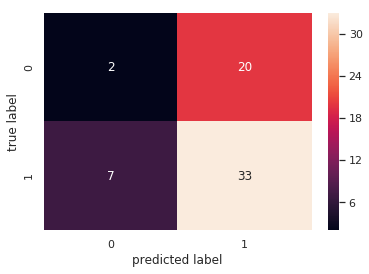

In [113]:
mat = confusion_matrix(y_test, yfit_rf)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [114]:
print(classification_report(y_test, yfit_rf))

              precision    recall  f1-score   support

           0       0.22      0.09      0.13        22
           1       0.62      0.82      0.71        40

    accuracy                           0.56        62
   macro avg       0.42      0.46      0.42        62
weighted avg       0.48      0.56      0.50        62



In [115]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier( n_estimators=120, max_depth=2)
gbc.fit(X_train, y_train)
yfit_gbc = gbc.predict(X_test)

accuracy_score(y_test, yfit_gbc)

0.5

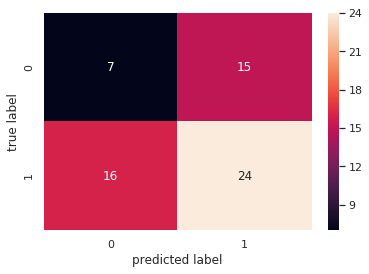

In [116]:
mat = confusion_matrix(y_test, yfit_gbc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [117]:
print(classification_report(y_test, yfit_gbc))

              precision    recall  f1-score   support

           0       0.30      0.32      0.31        22
           1       0.62      0.60      0.61        40

    accuracy                           0.50        62
   macro avg       0.46      0.46      0.46        62
weighted avg       0.51      0.50      0.50        62



#  3.5.

In [0]:
#볼린저 밴드로 Side 생성

def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [0]:
window=20
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)

In [0]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price')

In [121]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion

side2 = pd.concat([bb_side_up,bb_side_down]).sort_index()
side2

date_time
2009-09-28 14:28:41   -1
2009-09-28 15:34:40   -1
2009-09-29 09:27:39   -1
2009-09-29 10:31:39   -1
2009-09-29 13:30:07   -1
2009-09-30 09:44:47    1
2009-09-30 15:05:38    1
2009-10-01 09:30:07    1
2009-10-02 09:32:42    1
2009-10-02 15:54:20    1
2009-10-05 10:09:51   -1
2009-10-07 15:41:33   -1
2009-10-09 15:15:22   -1
2009-10-13 10:02:16    1
2009-10-14 09:34:13   -1
2009-10-15 14:54:33   -1
2009-10-16 09:38:27    1
2009-10-19 11:35:03   -1
2009-10-20 09:30:12   -1
2009-10-20 11:48:54    1
2009-10-21 15:30:21    1
2009-10-22 14:41:20   -1
2009-10-23 11:22:52    1
2009-10-23 13:40:54    1
2009-10-26 11:30:36    1
2009-10-27 09:42:46    1
2009-10-27 10:02:21    1
2009-10-27 13:08:57    1
2009-10-27 15:34:39    1
2009-10-28 09:36:43    1
                      ..
2019-06-14 15:18:27   -1
2019-06-17 09:30:00    1
2019-06-17 15:07:19    1
2019-06-18 09:39:43   -1
2019-06-18 15:44:01    1
2019-06-18 15:55:10    1
2019-06-19 09:57:29   -1
2019-06-19 14:01:58   -1
2019-06-19 15:1

In [122]:
#이번엔 ptsl = [0,2]로 설정, 나머지는 같음

pt_sl_3 = [0,2]
target = DailyVol



events4 = labeling.get_events(close, t_events, pt_sl_3, target, min_ret=0.01, num_threads=1 , side_prediction = side2)
events4.head()

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:122: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:134: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side_prediction.loc[target.index]


,side,t1,trgt
2009-10-02 09:32:42,1.0,2010-05-06 14:49:50,0.010414
2009-10-02 10:34:31,NaN,NaT,0.010400
2009-10-05 12:55:39,NaN,NaT,0.011719
2009-10-06 09:31:29,NaN,NaT,0.016259
2009-10-06 11:16:28,NaN,NaT,0.017185


In [123]:
bins4 = labeling.get_bins(events4,close)
bins4

#label이 다 0임.

,ret,trgt,bin,side
2009-10-02 09:32:42,-0.248122,0.010414,0,1.0
2009-10-13 10:02:16,-0.022644,0.011074,0,1.0
2009-10-14 09:34:13,-0.020764,0.010597,0,-1.0
2009-10-16 09:38:27,-0.024795,0.010277,0,1.0
2009-10-23 11:22:52,-0.021655,0.010113,0,1.0
2009-10-27 10:02:21,-0.022727,0.010398,0,1.0
2009-10-30 11:38:14,-0.261173,0.012099,0,1.0
2009-11-02 12:37:26,-0.252372,0.014020,0,1.0
2009-11-04 15:43:57,-0.257618,0.012348,0,1.0
2009-11-05 13:48:34,-0.023188,0.011507,0,-1.0


In [124]:
bins4.bin.value_counts()

0    289
Name: bin, dtype: int64

In [125]:
features2 = (pd.DataFrame()
            .assign(vol = events4.trgt)
            .assign(side = side2)
            .assign(srl_corr = srl_corr)
            .drop_duplicates()
            .dropna())
features2

,vol,side,srl_corr
2009-10-02 09:32:42,0.010414,1.0,-0.775166
2009-10-13 10:02:16,0.011074,1.0,-0.152978
2009-10-14 09:34:13,0.010597,-1.0,-0.105152
2009-10-16 09:38:27,0.010277,1.0,-0.033346
2009-10-23 11:22:52,0.010113,1.0,0.333561
2009-10-27 10:02:21,0.010398,1.0,-0.079453
2009-10-30 11:38:14,0.012099,1.0,-0.347701
2009-11-02 12:37:26,0.014020,1.0,-0.067175
2009-11-04 15:43:57,0.012348,1.0,0.137498
2009-11-05 13:48:34,0.011507,-1.0,0.012805


In [126]:
Xy2 = (pd.merge_asof(features2, bins4.bin, 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy2

,vol,side,srl_corr,bin
2009-10-02 09:32:42,0.010414,1.0,-0.775166,0
2009-10-13 10:02:16,0.011074,1.0,-0.152978,0
2009-10-14 09:34:13,0.010597,-1.0,-0.105152,0
2009-10-16 09:38:27,0.010277,1.0,-0.033346,0
2009-10-23 11:22:52,0.010113,1.0,0.333561,0
2009-10-27 10:02:21,0.010398,1.0,-0.079453,0
2009-10-30 11:38:14,0.012099,1.0,-0.347701,0
2009-11-02 12:37:26,0.014020,1.0,-0.067175,0
2009-11-04 15:43:57,0.012348,1.0,0.137498,0
2009-11-05 13:48:34,0.011507,-1.0,0.012805,0


In [0]:
# Random Forest

# X는 side
# y는 bin (레이블)

X2 = Xy2.drop('bin',axis=1).values
y2 = Xy2.bin.values

#train test split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2,shuffle=False)

In [128]:
rf2 = RandomForestClassifier(n_estimators=100,max_depth=2)
rf2.fit(X_train2, y_train2)



# 예측값

yfit_rf2 = rf2.predict(X_test2)

X_test2.ravel()

array([ 0.01348916, -1.        ,  0.14539063,  0.01574518,  1.        ,
       -0.07502153,  0.01448391,  1.        , -0.12947751,  0.01072229,
       -1.        ,  0.13074583,  0.01006706,  1.        ,  0.24317037,
        0.01308657, -1.        ,  0.07903833,  0.01328415, -1.        ,
        0.10917293,  0.02355485,  1.        , -0.13821665,  0.01988008,
       -1.        , -0.02605307,  0.01890867, -1.        , -0.39495538,
        0.01364354, -1.        ,  0.18390936,  0.01107042, -1.        ,
       -0.4944586 ,  0.01054239,  1.        ,  0.44712709,  0.01164806,
        1.        , -0.03805781,  0.01231568, -1.        , -0.16222537,
        0.01093015, -1.        , -0.09660272,  0.01427019,  1.        ,
        0.15219487,  0.01213161,  1.        , -0.45128463,  0.01168303,
        1.        , -0.37992869,  0.01073571,  1.        , -0.28700731,
        0.01020655, -1.        ,  0.07024774,  0.01021809, -1.        ,
        0.04081309,  0.01023956,  1.        ,  0.27421854,  0.01

In [129]:
yfit_rf2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [130]:
accuracy_score(y_test2, yfit_rf2)

1.0

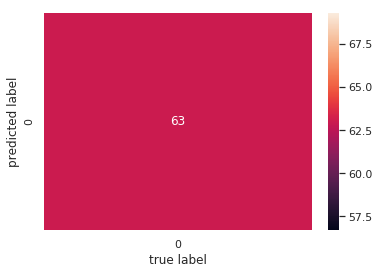

In [131]:
mat = confusion_matrix(y_test2, yfit_rf2)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [132]:
print(classification_report(y_test2, yfit_rf2))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [0]:
# 애초에 레이블이 다 0이기 때문에 다 0으로 예측할 수 밖에 없음.